In [1]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math

In [2]:
pd.options.display.max_columns = None

In [3]:
# Load trades
co_5_trades = pd.read_csv(
    "/Users/jakemoore/Code/kaiseki/data/trades_CO10-14.09.2018.csv",
    dtype={
        "Date": str,
        "Time": str,
        "Price": np.float64,
        "Volume": np.float64,
        "Market Flag": str,
    },
)

# Set the index
co_5_trades["timestamp"] = co_5_trades["Date"] + " " + co_5_trades["Time"]
co_5_trades["timestamp"] = pd.to_datetime(
    co_5_trades["timestamp"], format="%m/%d/%Y %H:%M:%S.%f"
)
co_5_trades.set_index("timestamp", inplace=True)
co_5_trades.drop(["Date", "Time"], axis=1, inplace=True)
co_5_trades.sort_index(inplace=True)

In [4]:
# Load order books
co_5_ob = pd.read_csv(
    "/Users/jakemoore/Code/kaiseki/data/quotes_CO10-14.09.2018.csv",
    dtype={
        "Date": str,
        "Time": str,
        "Bid Price": np.float64,
        "Bid Size": np.float64,
        "Ask Price": np.float64,
        "Ask Size": np.float64,
        "Market Flag": str,
        "Quote Condition": str,
    },
)

# Set the index
co_5_ob["timestamp"] = co_5_ob["Date"] + " " + co_5_ob["Time"]
co_5_ob["timestamp"] = pd.to_datetime(
    co_5_ob["timestamp"], format="%m/%d/%Y %H:%M:%S.%f"
)
co_5_ob.set_index("timestamp", inplace=True)
co_5_ob.drop(["Date", "Time"], axis=1, inplace=True)
co_5_ob.sort_index(inplace=True)

In [5]:
# drop the useless columns
co_5_trades.drop("Market Flag", inplace=True, axis=1)
co_5_ob.drop("Quote Condition", inplace=True, axis=1)
co_5_ob.drop("Market Flag", inplace=True, axis=1)

In [6]:
# Rename columns
co_5_trades.columns = ["price", "volume"]
co_5_ob.columns = ["bid_price", "bid_size", "ask_price", "ask_size"]

In [7]:
# Copy
trades = co_5_trades.copy()
ob = co_5_ob.copy()

# Truncate trades and books to some specific window
trades_idx = trades.index.copy()
trades.index = trades.index.ceil("10ms")
ob.index = ob.index.ceil("10ms")
ob = ob.resample("10ms").last()

# Generate series of time
df_ts = pd.DataFrame(index=pd.date_range(trades.index.min(), trades.index.max(), freq="10ms"))
df_ts.index.name = "timestamp"
ob = df_ts.join(ob, how="left")

# ffill books data
ob.fillna(method="ffill", inplace=True)

In [8]:
# Merge data frames
taq = trades.join(ob, how="left")

In [9]:
# features engineering
taq['mid'] = (taq['bid_price'] + taq['ask_price']) / 2.0

taq.loc[:,'volume_weighted_mid'] = (taq.loc[:,'bid_price'] * taq.loc[:,'ask_size']
+ taq.loc[:,'ask_price'] * taq.loc[:,'bid_size']) / (taq.loc[:,'bid_size']+taq.loc[:,'ask_size'])

taq['direction_volume'] = np.where(taq['price'] < taq['mid'], taq['volume']*(-1), taq['volume'])

taq['returns'] = taq['mid'].pct_change()

In [10]:
# order book imbalance function
def obi(quotes):
    qdf = quotes.copy()

    qdf['mid_change'] = ((qdf['bid_price'] + qdf['ask_price']) / 2.0).diff().div(0.01)
    
    qdf['prev_bidprice'] = qdf['bid_price'].shift()
    qdf['prev_bidsize'] = qdf['bid_size'].shift()
    qdf['prev_askprice'] = qdf['ask_price'].shift()
    qdf['prev_asksize'] = qdf['ask_size'].shift()

    # Fix any missing/invalid data
    qdf.replace([np.inf, np.NINF], np.nan, inplace=True)
    qdf.fillna(method="ffill", inplace=True)
    qdf.fillna(method="bfill", inplace=True)
    
    bid_geq = qdf['bid_price'] >= qdf['prev_bidprice']
    bid_leq = qdf['bid_price'] <= qdf['prev_bidprice']
    ask_geq = qdf['ask_price'] >= qdf['prev_askprice']
    ask_leq = qdf['ask_price'] <= qdf['prev_askprice']
    
    qdf['ofi'] = np.zeros(len(qdf))
    qdf['ofi'].loc[bid_geq] += qdf['bid_size'].loc[bid_geq]
    qdf['ofi'].loc[bid_leq] -= qdf['prev_bidsize'].loc[bid_leq]
    qdf['ofi'].loc[ask_geq] += qdf['prev_asksize'].loc[ask_geq]
    qdf['ofi'].loc[ask_leq] -= qdf['ask_size'].loc[ask_leq]    
    
    return qdf

In [11]:
taq = obi(taq)

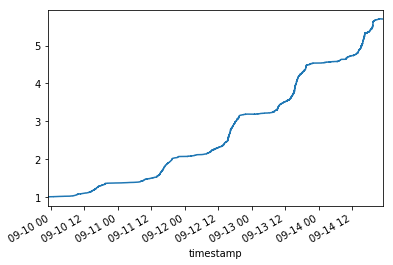

0.6135301262468255


In [12]:
# Parameters
rolling_length = "10s"
flow_amount = 50

# trade flow signal
taq['flow_long_sig'] = np.where(taq['direction_volume'].rolling(rolling_length).sum() > flow_amount, 1, 0)
taq['flow_short_sig'] = np.where(taq['direction_volume'].rolling(rolling_length).sum() < - flow_amount, -1, 0)
taq['flow_sig'] = taq['flow_long_sig'] + taq['flow_short_sig']

# VWM signal
taq['vwm_long_sig'] = np.where(taq['volume_weighted_mid'] > taq['mid'], 1, 0)
taq['vwm_short_sig'] = np.where(taq['volume_weighted_mid'] < taq['mid'], -1, 0)
taq['vwm_sig'] = taq['vwm_long_sig'] + taq['vwm_long_sig']

# OBI signal
taq['obi_long_sig'] = np.where(taq['ofi'].rolling(rolling_length).sum() > flow_amount, 1, 0)
taq['obi_short_sig'] = np.where(taq['ofi'].rolling(rolling_length).sum() < - flow_amount, -1, 0)
taq['obi_sig'] = taq['obi_long_sig'] + taq['obi_short_sig']

# combined signal
taq['comb_sig'] = (taq['vwm_sig']*0.666) + (taq['flow_sig']*0.333)
# taq['comb_sig'] = taq['flow_sig']

# calc PNL - can add in long and short pnl below
taq['total_pnl'] = taq['comb_sig'].shift(1) * taq['returns']

# taq['long_pnl'] = taq['long_sig'].shift(1) * taq['returns']
# taq['short_pnl'] = taq['short_sig'].shift(1) * taq['returns']

# calculate whether +ve or -ve pnl
taq['pnl+'] = np.where(taq['total_pnl'] > 0, taq['total_pnl'], 0)
taq['pnl+'] = taq['pnl+'].replace(0, np.NaN) 
taq['pnl-'] = np.where(taq['total_pnl'] < 0, taq['total_pnl'], 0)
taq['pnl-'] = taq['pnl-'].replace(0, np.NaN) 

# calculate percentage of winners
winners = taq['pnl+'].count()
losers = taq['pnl-'].count()
ratio = winners / (winners + losers)
winners_return = taq['pnl+'].mean()

# plot 'pnl' chart
taq['cum_pnl'] = (1 + taq['total_pnl']).cumprod()
taq['cum_pnl'].plot()
plt.show()
print(ratio)


In [13]:
for step in range(1, 51):
    taq[step] = taq['mid'].shift(-step*10) - taq['mid']

taq['sig2'] = taq['comb_sig'].replace(0, np.NaN) 

# create event stats
taq['0.1sec_effect'] = taq['sig2'] * taq[1]
taq['0.5sec_effect'] = taq['sig2'] * taq[5]
taq['1.0sec_effect'] = taq['sig2'] * taq[10]
taq['3.0sec_effect'] = taq['sig2'] * taq[30]
taq['5.0sec_effect'] = taq['sig2'] * taq[50]

# print event impacts for long signals
print('0.1 sec effect: ' + str((taq['0.1sec_effect']).mean()))
print('0.5 sec effect: ' + str((taq['0.5sec_effect']).mean()))
print('1.0 sec effect: ' + str((taq['1.0sec_effect']).mean()))
print('3.0 sec effect: ' + str((taq['3.0sec_effect']).mean()))
print('5.0 sec effect: ' + str((taq['5.0sec_effect']).mean()))

0.1 sec effect: 0.0013836674184196094
0.5 sec effect: 0.002073944891016557
1.0 sec effect: 0.0024498412997587117
3.0 sec effect: 0.002652506811988815
5.0 sec effect: 0.0027190508997283033


In [ ]:
taq[1].describe()

In [ ]:
# put together reservation price based on 3 factors plus inventory
# can we use the same scaling - 1 to 5 for each based on 'normal size'

In [ ]:
price = taq['mid'].resample('1s').last()

In [ ]:
price = pd.DataFrame(price)

In [ ]:
price['return'] = price.pct_change()
price['sigma'] = price['return'].rolling(60).std()

In [ ]:
price['sigma'].plot()

In [ ]:
price['09-12-2018 09:00:00' : '09-12-2018 12:00:00']

In [ ]:
holding_period = 5
price['spread'] = price['mid'] * price['sigma'] * math.sqrt(holding_period)
price['spread'].plot()